I'll be trying to use a VGG16 (and some others) using Transfer learning to try and recognise the faces of my 109 mangaset!

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image 
import skimage.io
import skimage.transform
from PIL import Image
import numpy as np
import math
import copy
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

import keras.backend as K
from keras import optimizers
from keras_vggface.vggface import VGGFace
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator



In [2]:
K.clear_session()
K.set_image_data_format( 'channels_last' ) 
nrow = 100
ncol = 100

In [3]:
# import os
# import shutil

# src_folder = '../../Data/checking_validity/face_train'
# textFileNames = os.listdir(src_folder)
# dst_folder = '../../Data/checking_validity/face_test'


# for i in range(len(textFileNames)):

#     src_dir = textFileNames[i]
#     files = os.listdir(src_folder+ '/' +src_dir)

#     print(files)
    
#     dir_exists = os.path.isdir(dst_folder+'/'+src_dir)
#     if not dir_exists:
#         os.mkdir(dst_folder+'/'+src_dir)
#     else:
#         print('save file in' + dst_folder+'/'+src_dir)
        
#     for j in range(round(len(files) / 4)):
#         src = src_folder+'/'+src_dir+'/'+files[j]
#         print(src)
#         dst = dst_folder+'/'+src_dir+'/'+files[j]
#         shutil.move(src, dst)

['One Piece 01.cbz.zip65.jpg', 'One Piece 01.cbz.zip74.jpg', 'One Piece 01.cbz.zip80.jpg', 'One Piece 01.cbz.zip86.jpg', 'One Piece 01.cbz.zip88.jpg', 'One Piece 01.cbz.zip96.jpg']
save file in../../Data/checking_validity/face_test/Coby
../../Data/checking_validity/face_train/Coby/One Piece 01.cbz.zip65.jpg
../../Data/checking_validity/face_train/Coby/One Piece 01.cbz.zip74.jpg
['One Piece 04.cbz.zip80.jpg']
save file in../../Data/checking_validity/face_test/Jango
['One Piece 04.cbz.zip96.jpg', 'One Piece 04.cbz.zip98.jpg', 'One Piece 04.cbz.zip99.jpg', 'One Piece 05.cbz.zip101.jpg', 'One Piece 05.cbz.zip104.jpg', 'One Piece 05.cbz.zip113.jpg', 'One Piece 05.cbz.zip119.jpg', 'One Piece 05.cbz.zip121.jpg', 'One Piece 05.cbz.zip125.jpg', 'One Piece 05.cbz.zip127.jpg', 'One Piece 05.cbz.zip82.jpg', 'One Piece 05.cbz.zip9.jpg']
save file in../../Data/checking_validity/face_test/Kaya
../../Data/checking_validity/face_train/Kaya/One Piece 04.cbz.zip96.jpg
../../Data/checking_validity/face_tr

In [3]:
#custom parameters
# 10 Names, 10 classes
src_folder = '../../Data/checking_validity/face_train'
textFileNames = os.listdir(src_folder)

nb_class = len(textFileNames)
hidden_dim = 512

vgg16 = VGGFace(include_top=False, input_shape=(nrow, ncol, 3))
for layer in vgg16.layers:
    layer.trainable = True

last_layer = vgg16.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
x = Dense(hidden_dim/2, activation='relu', name='fc8')(x)
x = Dense(hidden_dim/2, activation='relu', name='fc9')(x)
out = Dense(nb_class, activation='softmax', name='fc10')(x)
vgg16 = Model(vgg16.input, out)
vgg16.summary()

# resnet = VGGFace(model='resnet50',include_top=False, input_shape=(nrow, ncol, 3))
# for layer in resnet.layers:
#     layer.trainable = True

# last_layer = resnet.get_layer('avg_pool').output
# x = Flatten(name='flatten')(last_layer)
# x = Dense(hidden_dim, activation='relu', name='fc6')(x)
# x = Dense(hidden_dim, activation='relu', name='fc7')(x)
# out = Dense(nb_class, activation='softmax', name='fc8')(x)
# resnet = Model(resnet.input, out)
# resnet.summary()

# senet = VGGFace(model='senet50',include_top=False, input_shape=(nrow, ncol, 3))
# for layer in senet.layers:
#     layer.trainable = True

# last_layer = senet.get_layer('avg_pool').output
# x = Flatten(name='flatten')(last_layer)
# x = Dense(hidden_dim, activation='relu', name='fc6')(x)
# x = Dense(hidden_dim, activation='relu', name='fc7')(x)
# out = Dense(nb_class, activation='softmax', name='fc8')(x)
# senet = Model(senet.input, out)
# senet.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 100, 100, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 100, 100, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 50, 50, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 25, 25, 128)       0     

In [4]:
import os
datasetDescriptor = '../../Data/checking_validity/face_train'
textFileNames = os.listdir(datasetDescriptor)
batch_size = 100
print(textFileNames)

['Coby', 'Jango', 'Kaya', 'Kuro', 'Monkey D. Luffy', 'Nami', 'Roronoa Zoro', 'Shanks', 'Usopp']


In [5]:
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

In [6]:
test_data_dir = '../../Data/checking_validity/face_test'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   # Add rotation 
                                   rotation_range=90)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 191 images belonging to 9 classes.


In [7]:
train_data_dir = '../../Data/checking_validity/face_train'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   # Add rotation
                                   rotation_range=90)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 251 images belonging to 9 classes.


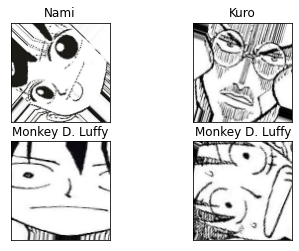

In [8]:
batch_shape = (batch_size,vgg16.input_shape[1] , 
               vgg16.input_shape[2], 
               vgg16.input_shape[3])

X = np.zeros(batch_shape)
y = np.zeros(batch_size)

X,y = train_generator.next()
nplot = 4 

for i in range(nplot):    
    plt.subplot(2,nplot/2,i+1)
    disp_image(X[i,:,:,:])
    title = (textFileNames[int(y[i])])
    plt.title(title)

In [9]:
vgg16.compile(loss='sparse_categorical_crossentropy',
                         optimizer=optimizers.Adam(lr=1e-5),
                         metrics=['accuracy'])

steps_per_epoch = train_generator.n // batch_size 
validation_steps = test_generator.n // batch_size 
nepochs = 100

history_vgg16 = vgg16.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
2/2 [==============================] - 5s 2s/step - loss: 2.1899 - accuracy: 0.1126 - val_loss: 2.1838 - val_accuracy: 0.1400
Epoch 2/100
2/2 [==============================] - 2s 984ms/step - loss: 2.1848 - accuracy: 0.1350 - val_loss: 2.1745 - val_accuracy: 0.1400
Epoch 3/100
2/2 [==============================] - 2s 876ms/step - loss: 2.1730 - accuracy: 0.1656 - val_loss: 2.1599 - val_accuracy: 0.2400
Epoch 4/100
2/2 [==============================] - 2s 778ms/step - loss: 2.1651 - accuracy: 0.2848 - val_loss: 2.1404 - val_accuracy: 0.3300
Epoch 5/100
2/2 [==============================] - 2s 851ms/step - loss: 2.1444 - accuracy: 0.3500 - val_loss: 2.1238 - val_accuracy: 0.4300
Epoch 6/100
2/2 [==============================] - 2s 839ms/step - loss: 2.1144 - accuracy: 0.4040 - val_loss: 2.0686 - val_accuracy: 0.5000
Epoch 7/100
2/2 [==============================] - 2s 772ms/step - loss: 2.0889 -

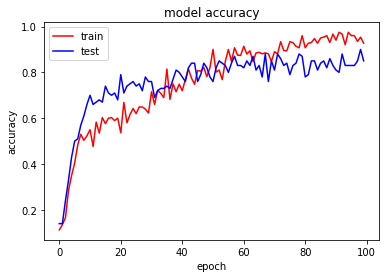

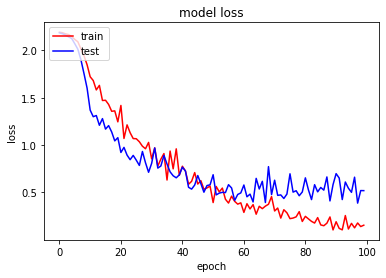

In [10]:
plt.plot(history_vgg16.history['accuracy'],'r')
plt.plot(history_vgg16.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history_vgg16.history['loss'],'r')
plt.plot(history_vgg16.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
X,y = test_generator.next()
y_pred = vgg16.predict(X)

#print(y)

y_true = []

for i in range(len(y)):
    filler = np.zeros(nb_class)
    location = y[i]
    filler[int(location)] = 1
    y_true.append(filler)


y_true = np.matrix(y_true)
y_pred = y_pred.round()

print('\n')
print(classification_report(y_true, y_pred))

cf = confusion_matrix(y_true, y_pred)

print(cf)
print(accuracy_score(y_true, y_pred) * 100) 



              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         1
           2       0.67      0.67      0.67         3
           3       1.00      0.50      0.67         6
           4       0.97      0.97      0.97        58
           5       0.84      1.00      0.91        21
           6       1.00      0.20      0.33         5
           7       0.00      0.00      0.00         1
           8       0.33      0.33      0.33         3

   micro avg       0.89      0.85      0.87       100
   macro avg       0.59      0.46      0.49       100
weighted avg       0.89      0.85      0.85       100
 samples avg       0.85      0.85      0.85       100



TypeError: Singleton array 4 cannot be considered a valid collection.

In [24]:
# resnet.compile(loss='sparse_categorical_crossentropy',
#                          optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#                          metrics=['accuracy'])

# steps_per_epoch = train_generator.n // batch_size 
# validation_steps = test_generator.n // batch_size 
# nepochs = 50

# resnet.fit_generator(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=nepochs,
#     validation_data=test_generator,
#     validation_steps=validation_steps)

Epoch 1/50
12/12 [==============================] - 9s 736ms/step - loss: 3.0593 - accuracy: 0.0606 - val_loss: 2.2577 - val_accuracy: 0.0444
Epoch 2/50
12/12 [==============================] - 6s 529ms/step - loss: 1.7631 - accuracy: 0.4372 - val_loss: 2.0667 - val_accuracy: 0.0333
Epoch 3/50
12/12 [==============================] - 6s 518ms/step - loss: 1.5542 - accuracy: 0.5208 - val_loss: 2.0584 - val_accuracy: 0.0556
Epoch 4/50
12/12 [==============================] - 6s 526ms/step - loss: 1.3638 - accuracy: 0.5628 - val_loss: 2.0899 - val_accuracy: 0.0444
Epoch 5/50
12/12 [==============================] - 7s 555ms/step - loss: 1.2824 - accuracy: 0.5498 - val_loss: 2.0518 - val_accuracy: 0.0444
Epoch 6/50
12/12 [==============================] - 7s 589ms/step - loss: 1.0641 - accuracy: 0.6580 - val_loss: 2.0216 - val_accuracy: 0.4500
Epoch 7/50
12/12 [==============================] - 7s 590ms/step - loss: 1.1247 - accuracy: 0.6364 - val_loss: 2.0203 - val_accuracy: 0.5778
Epoch 

In [23]:
# senet.compile(loss='sparse_categorical_crossentropy',
#                          optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#                          metrics=['accuracy'])

# steps_per_epoch = train_generator.n // batch_size 
# validation_steps = test_generator.n // batch_size 
# nepochs = 20

# senet.fit_generator(
#     train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=nepochs,
#     validation_data=test_generator,
#     validation_steps=validation_steps)

Epoch 1/20
12/12 [==============================] - 9s 745ms/step - loss: 1.0200 - accuracy: 0.7186 - val_loss: 1.7623 - val_accuracy: 0.5722
Epoch 2/20
12/12 [==============================] - 8s 636ms/step - loss: 0.9939 - accuracy: 0.6537 - val_loss: 1.6099 - val_accuracy: 0.5611
Epoch 3/20
12/12 [==============================] - 8s 641ms/step - loss: 1.0189 - accuracy: 0.6407 - val_loss: 2.5955 - val_accuracy: 0.5722
Epoch 4/20
12/12 [==============================] - 8s 640ms/step - loss: 0.7714 - accuracy: 0.7186 - val_loss: 1.6774 - val_accuracy: 0.5500
Epoch 5/20
12/12 [==============================] - 8s 640ms/step - loss: 0.7388 - accuracy: 0.7576 - val_loss: 1.4295 - val_accuracy: 0.5778
Epoch 6/20
12/12 [==============================] - 8s 655ms/step - loss: 0.7118 - accuracy: 0.7446 - val_loss: 2.6505 - val_accuracy: 0.5667
Epoch 7/20
12/12 [==============================] - 8s 650ms/step - loss: 0.5747 - accuracy: 0.8225 - val_loss: 4.3036 - val_accuracy: 0.5889
Epoch 